In [1]:
import tensorflow as tf
import numpy as np
seed = 123
np.random.seed(seed)
import cifar10_utils
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Lambda, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPool2D, AvgPool2D
from keras.datasets import fashion_mnist
from keras import regularizers, optimizers
from keras.applications import VGG16
import itertools
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sn
import fmnist_utils1

/home/hasan/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/hasan/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/hasan/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/hasan/anaconda3/envs/tf_gpu/lib/python3.7/s

In [2]:
import tensorflow as tf
import os
from keras.backend.tensorflow_backend import set_session
os.environ["CUDA_VISIBLE_DEVICES"]="0"
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.9

set_session(tf.Session(config=config))

In [3]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')



#z-score
mean = np.mean(x_train,axis=(0,1))
std = np.std(x_train,axis=(0,1))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

datagen = ImageDataGenerator(
          featurewise_center=False,            # set input mean to 0 over the dataset
          samplewise_center=False,             # set each sample mean to 0
          featurewise_std_normalization=False, # divide inputs by std of the dataset
          samplewise_std_normalization=False,  # divide each input by its std
          zca_whitening=False,                 # apply ZCA whitening
          rotation_range=30,                   # randomly rotate images in the range (degrees, 0 to 180)
          zoom_range = 0.1,                    # Randomly zoom image 
          width_shift_range=0.1,               # randomly shift images horizontally (fraction of total width)
          height_shift_range=0.1,              # randomly shift images vertically (fraction of total height)
          horizontal_flip=False,               # randomly flip images
          vertical_flip=False)                 # randomly flip images

#datagen.fit(xtrain)
nclasses = 10
base_epochs = 10
dim = 28
epochs = 15
batch_size = 1024
class_names = ['others','Tshirt', 'Trouser', 'PullOver', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'AnkelBoat']

In [4]:
def df_reshape(df):
    print("Previous shape, pixels are in 1D vector:", df.shape)
    df = df.reshape(-1, dim, dim, 1) 
    # -1 means the dimension doesn't change, so 42000 in the case of xtrain and 28000 in the case of test
    print("After reshape, pixels are a 28x28x1 3D matrix:", df.shape)
    return df

In [5]:
x_train = df_reshape(x_train) # numpy.ndarray type
x_test = df_reshape(x_test) # numpy.ndarray type

Previous shape, pixels are in 1D vector: (60000, 28, 28)
After reshape, pixels are a 28x28x1 3D matrix: (60000, 28, 28, 1)
Previous shape, pixels are in 1D vector: (10000, 28, 28)
After reshape, pixels are a 28x28x1 3D matrix: (10000, 28, 28, 1)


In [6]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv2D, MaxPool2D, AvgPool2D
from keras import regularizers, optimizers
from keras.applications import VGG16
from keras.utils import np_utils
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

def data_split(n_classes, data, labels, seed=123, other_base=1):
    np.random.seed(seed)

    # python pass parameters as reference, it's better to make a copy here
    labels_copy = np.copy(labels)
    
#     other_base = 6 - n_classes
    
    if n_classes < 2:
        raise ValueError('n_classes must be between 2 and 10')

    # indices of classes that are not part of the 'other' class
    class_indices = np.argwhere(labels_copy < (n_classes - 1))[:,0]
    
    num_of_each_class = class_indices.shape[0]//(n_classes-1)

    # draw sample from 'other' class
    other_indices = np.random.choice(np.argwhere(labels_copy >= (n_classes + other_base - 1))[:,0], num_of_each_class, replace=False)

    # combine indices os the selected classs and the 'other' class
    all_indices = np.concatenate((class_indices, other_indices))

    # create new train and test datasets and labels
    selected_data = data[all_indices, :]
    selected_labels = labels_copy[all_indices]  #deep copy

    # adjust label of 'other' class: set to n_classes - 1, i.e. if we have two classes, cats and other, than cats will
    # have 0 and other will have 1
    selected_labels[selected_labels >= (n_classes - 1)] = n_classes - 1
    
    return (selected_data, selected_labels)

def generate_data(cur_target_class_ids, full_target_class_ids, data, labels, refining, seed=123):
    
    np.random.seed(seed)
    
    num_of_each_class = 6000
    
    n_final_classes_including_other = 10
    full_class_ids = np.arange(1, n_final_classes_including_other+1)
    
    if refining == True:
        other_class_ids = np.setxor1d(full_class_ids, cur_target_class_ids)
    else:
        other_class_ids = np.setxor1d(full_class_ids, full_target_class_ids)

    labels_copy = np.copy(labels)
    
    target_class_indices = np.array([], dtype='int32')
    for class_id in cur_target_class_ids:
            target_class_indices = np.append(target_class_indices, np.argwhere(labels_copy == class_id-1)[:,0])
    # TODO: temp code
    np.random.shuffle(target_class_indices)
    print(target_class_indices[:10])
    labels_copy = labels_copy.reshape(60000,1)
    # create new train and test datasets and labels
    target_class_data = data[target_class_indices, :]
    target_class_labels = np.squeeze(labels_copy[target_class_indices, :])
    target_class_labels_copy = np.copy(target_class_labels)
    
    # Reasign the index of target-classes, starting from 1
    for i, class_id in enumerate(cur_target_class_ids):
        target_class_labels[np.argwhere(target_class_labels_copy == class_id-1)[:, 0]] = i+1
        
    # Other-class
    all_other_class_indices = np.array([], dtype='int32')
    for class_id in other_class_ids:
        if class_id == other_class_ids[0]: #TODO
            all_other_class_indices = np.append(all_other_class_indices, np.argwhere(labels_copy == class_id-1)[:,0])
    
    print('current other class: ' + str(other_class_ids))
    print('current target class: ' + str(cur_target_class_ids))
    print('all target target class: ' + str(full_target_class_ids))
    print('all class: ' + str(full_class_ids))
    print('all other class indices: ' + str(len(all_other_class_indices)))
    other_class_indices = np.random.choice(all_other_class_indices, num_of_each_class)
    
    other_class_data = data[other_class_indices, :]
    
    # set 'other' label to zero
    other_class_labels = np.array([0]*num_of_each_class)
    
    print(target_class_labels.shape, other_class_labels.shape)
    
    selected_data = np.concatenate((target_class_data, other_class_data))
    selected_labels = np.concatenate((target_class_labels, other_class_labels))
    
    return (selected_data, selected_labels)


def create_base_model(dim=28):
    

    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(dim,dim,1)))
    model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu',))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=64, kernel_size=(5,5), padding='same', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(5,5), padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(120, activation='relu'))
    model.add(Dense(84, activation='relu'))
    #model.add(Dense(10, activation='softmax'))
    return model


def training(model, num_classes_including_other, train_data, train_labels, data_generator, batch_size, epochs):
    
    y_train_categorical = np_utils.to_categorical(train_labels, num_classes_including_other)
    
    opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
    model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
    training_log_ep75 = model.fit(train_data, y_train_categorical, batch_size=batch_size,epochs=epochs, verbose=1, shuffle=False)
    
    opt_rms = keras.optimizers.rmsprop(lr=0.0005,decay=1e-6)
    model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
    training_log_ep100 = model.fit(train_data, y_train_categorical, batch_size=batch_size, epochs=epochs, verbose=1, shuffle=False)

    opt_rms = keras.optimizers.rmsprop(lr=0.0003,decay=1e-6)
    model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
    training_log_ep125 = model.fit(train_data, y_train_categorical, batch_size=batch_size,epochs=epochs, verbose=1, shuffle=False)
    
    return 0

def tuning(model, num_classes_including_other, train_data, train_labels, data_generator, batch_size, epochs):
    
    y_train_categorical = np_utils.to_categorical(train_labels, num_classes_including_other)

    opt_rms = keras.optimizers.rmsprop(lr=0.0003,decay=1e-6)
    model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
    training_log_ep125 = model.fit_generator(
                                    data_generator.flow(train_data, y_train_categorical, batch_size=batch_size),
                                    steps_per_epoch=train_data.shape[0] // batch_size,epochs=epochs, verbose=1)
     

def evaluate(model, cur_target_class_ids,test_data, test_labels, batch_size):
    acc = []
    loss = []
    confusion_mtx = []
    num_classes = len(cur_target_class_ids)+1
    for i, class_id in enumerate(cur_target_class_ids):
        print(i,class_id)
        target_class_indices = np.argwhere(test_labels==class_id-1)[:, 0]
        target_test_data = test_data[target_class_indices]
#         print(len(target_test_data))
        target_test_labels = np.array([i+1]*target_test_data.shape[0])
        target_test_labels_categorical = np_utils.to_categorical(target_test_labels, num_classes)
        scores = model.evaluate(target_test_data, target_test_labels_categorical, batch_size, verbose=0)
        loss += [scores[0]]
        acc += [scores[1]]
        y_pred_categorical = model.predict(target_test_data)
        y_pred = np.argmax(y_pred_categorical, axis=1)
        print('y_sum ' + str(np.sum(y_pred)))
        unique, counts = np.unique(y_pred, return_counts=True)
        xor_result = np.setxor1d(unique, np.arange(0, num_classes))
        if len(xor_result) != 0:
            y_pred = np.concatenate((y_pred, xor_result))
            unique, counts = np.unique(y_pred, return_counts=True) 
        counts[0] = class_id  # set the first column to the class_id
        if len(counts) != num_classes:
            raise ValueError('TODO: handle dim exception: (%d, %d) ' %(len(counts), num_classes)) 
        confusion_mtx.append(counts.tolist())
    return acc, loss, np.array(confusion_mtx)

def plot_confusion_mtx(confusion_mtx, class_names):
    n_classes = len(confusion_mtx)
    class_ids = confusion_mtx[:, 0]
    df_cm = pd.DataFrame(confusion_mtx[:, 1:], index = [class_names[i] for i in class_ids] ,
                  columns =[class_names[i] for i in class_ids])
    plt.figure()
    sn.heatmap(df_cm, annot=True, cmap='summer')
    plt.show()
    return 

def training_with_GC(model, full_target_class_ids, epochs, x_train, y_train, x_test, y_test, data_generator, batch_size, refining):
    acc_GC = []
    loss_GC = []
    for i in range(len(full_target_class_ids)): # exclusive 'other'
        cur_target_class_ids = full_target_class_ids[:i+1]
        if(i >= 1):
            print('-----Adding a new class (total classes including other: %s)------' % str(i+2))
            for layer in model.layers:
                layer.trainable=False    
        model.add(Dense(i+2, activation='softmax'))
        (cur_train_data, cur_train_labels) = generate_data(cur_target_class_ids, full_target_class_ids, 
                                                           x_train, y_train, refining)
        data_generator.fit(cur_train_data)
        training(model, i+2, cur_train_data, cur_train_labels, data_generator, batch_size, epochs)
        print('-----Fine Tuning------')
        for layer in model.layers[-3:-1]:
            layer.trainable = True
        tuning(model, i+2, cur_train_data, cur_train_labels, data_generator, batch_size, epochs)
        # set back to untrainable
        for layer in model.layers[-3:-1]:
            layer.trainable = False
        acc, loss, confusion_mtx = evaluate(model, cur_target_class_ids, x_test, y_test, 100)
        acc_GC += [acc]
        loss_GC += [loss]
        model.pop()
        # plot confusion mtx
    return acc_GC, loss_GC

def plot_result(acc_all_class_from_scratch, acc_GC, acc_GC_refining, full_target_class_ids, class_names):
    
    def get_leading_zeros(arr):
        n_leading_zeros = 0
        for eli in arr:
            if eli != 0:
                break
            else:
                n_leading_zeros += 1
        return n_leading_zeros
    
    
    num_classes = len(full_target_class_ids)
    
    acc_GC_for_each_class = np.zeros((num_classes, num_classes))
    
    for i in range(num_classes):
        for j in range(len(acc_GC[i])):
            acc_GC_for_each_class[j][i] = acc_GC[i][j]
            
    acc_GC_refining_for_each_class = np.zeros((num_classes, num_classes))
    
    for i in range(num_classes):
        for j in range(len(acc_GC_refining[i])):
            acc_GC_refining_for_each_class[j][i] = acc_GC_refining[i][j]
    
    num_logs_for_each_class = np.arange(num_classes, 0, -1)
    acc_GC_avg_for_each_class = np.sum(acc_GC_for_each_class, axis=1)/num_logs_for_each_class
    acc_GC_refining_avg_for_each_class = np.sum(acc_GC_refining_for_each_class, axis=1)/num_logs_for_each_class

    for i in range(num_classes):
        n_leading_zeros = get_leading_zeros(acc_GC_refining_for_each_class[i])
        l = len(acc_GC_refining_for_each_class[i])
        plt.plot(np.arange(n_leading_zeros, l), acc_GC_for_each_class[i][n_leading_zeros:], label='Growing Classifier', marker='^')
        plt.plot(np.arange(n_leading_zeros, l), acc_GC_refining_for_each_class[i][n_leading_zeros:], label='Growing Classifier (Refining)', marker='^')
        plt.plot(np.arange(len(acc_GC_refining_for_each_class[i])), [acc_all_class_from_scratch[i]]*l, label='Train From Scratch', marker='^')
        plt.legend()
        plt.xlabel('num classes')
        plt.ylabel('accuracy')
        plt.title(class_names[full_target_class_ids[i]])
        plt.show()

        
#     print(acc_GC_for_each_class)

    for i in range(num_classes):
        n_leading_zeros = get_leading_zeros(acc_GC_for_each_class[i])
        l = len(acc_GC_for_each_class[i])
        plt.plot(np.arange(n_leading_zeros, l), acc_GC_for_each_class[i][n_leading_zeros:], label=class_names[full_target_class_ids[i]], marker='^')
    plt.legend()
    plt.xlabel('num classes')
    plt.ylabel('accuracy')
    plt.title('GC on all classes (No Refining)')
    plt.show()

    for i in range(num_classes):
        n_leading_zeros = get_leading_zeros(acc_GC_refining_for_each_class[i])
        l = len(acc_GC_refining_for_each_class[i])
        plt.plot(np.arange(n_leading_zeros, l), acc_GC_refining_for_each_class[i][n_leading_zeros:], label=class_names[full_target_class_ids[i]], marker='^')
    plt.legend()
    plt.xlabel('num classes')
    plt.ylabel('accuracy')
    plt.title('GC on all classes (Refining)')
    plt.show()

    plt.plot(np.arange(num_classes), acc_GC_avg_for_each_class, label='Growing Classifer', marker='^')
    plt.plot(np.arange(num_classes), acc_GC_refining_avg_for_each_class, label='Growing Classifer (Refining)', marker='^')
    plt.plot(np.arange(num_classes), acc_all_class_from_scratch, label='train from scratch', marker='^')
    plt.legend()
    plt.xlabel('class ID ' + str([class_names[el] for el in full_target_class_ids]))
    plt.ylabel('accuracy')
    plt.title('GC (with and without refining) v.s. Train from scratch')
    plt.show()
    
    return


# General Procedure
def one_run1(model, x_train, y_train, x_test, y_test, batch_size, full_target_class_ids,base_epochs,class_names,datagen,initial_weights):
    seed=123
#     np.random.seed(seed)
    num_classes_excluding_other = len(full_target_class_ids)
    num_classes_including_other = num_classes_excluding_other + 1


    
    ### Train From Scratch ###
    print('\n======Training From Scratch=========\n')
    #weights_train_from_scratch = list(initial_weights)
    # use the same initial weights
    model.load_weights(initial_weights)
    #model.set_weights(initial_weights)
    for layer in model.layers:
        layer.trainable = True
    model.add(Dense(num_classes_including_other, activation='softmax'))

    # in train-from-scratch, feed all target class at the begining, 
    # i.e., cur_target_class_ids is same with full_target_class_ids
    cur_target_class_ids = np.copy(full_target_class_ids)

    (cur_train_data, cur_train_labels) = generate_data(cur_target_class_ids, full_target_class_ids, x_train, y_train, False, seed)
    datagen.fit(cur_train_data)
    training(model, num_classes_including_other, cur_train_data, cur_train_labels, 
                           datagen, batch_size, base_epochs)
#    training(model, num_classes_including_other, x_train, y_train, datagen, batch_size, base_epochs)

    acc_all_class_from_scratch, loss_all_class_from_scratch, scratch_confusion_mtx = evaluate(model, cur_target_class_ids, 
                                                                       x_test, y_test, batch_size)
    
    #remove the last layer
    model.pop()
    
    print(acc_all_class_from_scratch)
    plot_confusion_mtx(scratch_confusion_mtx, class_names)
        ### Growing Classifier (Refining) ###
    print('\n=====Training Using Growing Classifier (new classes appeared in \'Other\' class before) ======\n')
    #weights_growing_classifier_refining = list(initial_weights)
    # use the same initial weights
    model.load_weights(initial_weights) 
    #model.set_weights(weights_growing_classifier_refining)
    for layer in model.layers: layer.trainable = True

    acc_GC_refining, loss_GC_refining = training_with_GC(model, full_target_class_ids, base_epochs, 
                                                         x_train, y_train, x_test, y_test,datagen, batch_size, True)
    
    #     ### Growing Classifier ###
    print('\n=====Training Using Growing Classifier (new classes never appeared in \'Other\' class before) ======\n')
    #weights_growing_classifier = list(initial_weights)
    # use the same initial weights
    model.load_weights(initial_weights) 
    #model.set_weights(weights_growing_classifier)

    for layer in model.layers: layer.trainable = True

    acc_GC, loss_GC = training_with_GC(model, full_target_class_ids, base_epochs, 
                                                    x_train, y_train, x_test, y_test, 
                                                     datagen, batch_size, False)
    

    plot_result(acc_all_class_from_scratch, acc_GC, acc_GC_refining, full_target_class_ids, class_names)

    return acc_all_class_from_scratch,acc_GC_refining,acc_GC
# General Procedure
def one_run(model, x_train, y_train, x_test, y_test, batch_size, full_target_class_ids, base_epochs, class_names):
    
#     np.random.seed(seed)
    num_classes_excluding_other = len(full_target_class_ids)
    num_classes_including_other = num_classes_excluding_other + 1


    
    ### Train From Scratch ###
    print('\n======Training From Scratch=========\n')
#     weights_train_from_scratch = list(initial_weights)
    # use the same initial weights
    #model.set_weights(initial_weights)
#     for layer in model.layers:
#         layer.trainable = True
#     model.add(Dense(num_classes_including_other, activation='softmax'))

    # in train-from-scratch, feed all target class at the begining, 
    # i.e., cur_target_class_ids is same with full_target_class_ids
    cur_target_class_ids = np.copy(full_target_class_ids)

#     (cur_train_data, cur_train_labels) = generate_data(cur_target_class_ids, full_target_class_ids, 
#                                                                x_train, y_train, False, seed)

#     datagen.fit(cur_train_data)

#     training(model, num_classes_including_other, cur_train_data, cur_train_labels, 
#                            datagen, batch_size, base_epochs)
    training(model, num_classes_excluding_other, x_train, y_train, datagen, batch_size, base_epochs)

    #acc_all_class_from_scratch, loss_all_class_from_scratch, scratch_confusion_mtx = evaluate(model, cur_target_class_ids, 
     #                                                                  x_test, y_test, batch_size)
    # remove the last layer
#     model.pop()
    
    #print(acc_all_class_from_scratch)
    #plot_confusion_mtx(scratch_confusion_mtx, class_names)
    
    ### Growing Classifier (Refining) ###
#     print('\n=====Training Using Growing Classifier (new classes appeared in \'Other\' class before) ======\n')
#     weights_growing_classifier_refining = list(initial_weights)
#     # use the same initial weights
#     model.set_weights(weights_growing_classifier_refining)
#     for layer in model.layers: layer.trainable = True

#     acc_GC_refining, loss_GC_refining = training_with_GC(model, full_target_class_ids, base_epochs, 
#                                                          x_train, y_train, x_test, y_test, 
#                                                                        datagen, batch_size, True)

#     ### Growing Classifier ###
#     print('\n=====Training Using Growing Classifier (new classes never appeared in \'Other\' class before) ======\n')
#     weights_growing_classifier = list(initial_weights)
#     # use the same initial weights
#     model.set_weights(weights_growing_classifier)

#     for layer in model.layers: layer.trainable = True

#     acc_GC, loss_GC = training_with_GC(model, full_target_class_ids, base_epochs, 
#                                                     x_train, y_train, x_test, y_test, 
#                                                      datagen, batch_size, False)
    
#     plot_result(acc_all_class_from_scratch, acc_GC, acc_GC_refining, full_target_class_ids, class_names)
     #
    #return acc_all_class_from_scratch
def one_run2(model, x_train, y_train, x_test, y_test, batch_size, full_target_class_ids,base_epochs,class_names):
    seed=123
#     np.random.seed(seed)
    num_classes_excluding_other = len(full_target_class_ids)
    num_classes_including_other = num_classes_excluding_other + 1


    
    ### Train From Scratch ###
    print('\n======Training From Scratch=========\n')
#     weights_train_from_scratch = list(initial_weights)
    # use the same initial weights
    model.load_weights(initial_weights)
    for layer in model.layers:
        layer.trainable = True
    model.add(Dense(num_classes_including_other, activation='softmax'))

    # in train-from-scratch, feed all target class at the begining, 
    # i.e., cur_target_class_ids is same with full_target_class_ids
    cur_target_class_ids = np.copy(full_target_class_ids)

    (cur_train_data, cur_train_labels) = generate_data(cur_target_class_ids, full_target_class_ids, x_train, y_train, False, seed)
    datagen.fit(cur_train_data)
    training(model, num_classes_including_other, cur_train_data, cur_train_labels, 
                           datagen, batch_size, base_epochs)
#    training(model, num_classes_including_other, x_train, y_train, datagen, batch_size, base_epochs)

    #acc_all_class_from_scratch, loss_all_class_from_scratch, scratch_confusion_mtx = evaluate(model, cur_target_class_ids, 
    #                                                                   x_test, y_test, batch_size)
    #remove the last layer
    model.pop()
    
    print(acc_all_class_from_scratch)
    plot_confusion_mtx(scratch_confusion_mtx, class_names)
        ### Growing Classifier (Refining) ###
    print('\n=====Training Using Growing Classifier (new classes appeared in \'Other\' class before) ======\n')
    #weights_growing_classifier_refining = list(initial_weights)
    # use the same initial weights
    #model.set_weights(weights_growing_classifier_refining)
    #for layer in model.layers: layer.trainable = True

    #acc_GC_refining, loss_GC_refining = training_with_GC(model, full_target_class_ids, base_epochs, 
    #                                                     x_train, y_train, x_test, y_test,datagen, batch_size, True)
    
    #     ### Growing Classifier ###
    #print('\n=====Training Using Growing Classifier (new classes never appeared in \'Other\' class before) ======\n')
    #weights_growing_classifier = list(initial_weights)
     # use the same initial weights
#     model.set_weights(weights_growing_classifier)

    #for layer in model.layers: layer.trainable = True

    #acc_GC, loss_GC = training_with_GC(model, full_target_class_ids, base_epochs, 
    #                                                x_train, y_train, x_test, y_test, 
    #                                                 datagen, batch_size, False)
    

    #plot_result(acc_all_class_from_scratch, acc_GC, acc_GC_refining, full_target_class_ids, class_names)

    return acc_all_class_from_scratch

In [7]:
model = create_base_model(dim)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        51264     
_________________________________________________________________
conv2d_4 (Conv2D)    

In [10]:
print('===============BASELINE Results On All Classes===========')

num_classes_excluding_other = 9
full_class_ids = np.arange(1, 11)  # 1-10
np.random.shuffle(full_class_ids)
#full_target_class_ids = full_class_ids[:num_classes_excluding_other]
#full_target_class_ids = [1,2,3,4,5,6,7,8,9]
#full_target_class_ids = [1,8,5,2,4,6,9,7,3]
full_target_class_ids = [1,7,4,2,5,3,8,6,9]


===============BASELINE Results On All Classes===========


In [11]:
cur_target_class_ids = np.copy(full_target_class_ids)
print(cur_target_class_ids)

[1 7 4 2 5 3 8 6 9]


In [12]:
cur_target_class_ids = np.copy(full_target_class_ids)

(cur_train_data, cur_train_labels) = generate_data(cur_target_class_ids, full_target_class_ids, x_train, y_train, False, seed)
datagen.fit(cur_train_data)

[32529 24414 38711 59727 12513 54771 39536 51406 53144 44588]
current other class: [10]
current target class: [1 7 4 2 5 3 8 6 9]
all target target class: [1, 7, 4, 2, 5, 3, 8, 6, 9]
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 6000
(54000,) (6000,)


In [13]:
#full_target_class_ids = full_class_ids[:11]
selected_class_names = [class_names[el] for el in full_target_class_ids]
print('selected classes: ' + str(selected_class_names))

cur_target_class_ids = np.copy(full_target_class_ids)

n_running_instance = 3


selected classes: ['Tshirt', 'Shirt', 'Dress', 'Trouser', 'Coat', 'PullOver', 'Sneaker', 'Sandal', 'Bag']


In [65]:
baseline_results = []
for i in range(n_running_instance):
    print('Running Instance ' + str(i) + ': ')
    baseline_result = one_run(model, x_train, y_train, x_test, y_test, batch_size,full_target_class_ids, base_epochs, class_names)
    baseline_results += [baseline_result]
baseline_results = np.array(baseline_results)

Running Instance 0: 

======Training From Scratch=========

Epoch 1/10
60000/60000 [==============================] - 7s 124us/step - loss: 0.1320 - acc: 0.9601
Epoch 2/10
60000/60000 [==============================] - 7s 110us/step - loss: 0.0828 - acc: 0.9683
Epoch 3/10
60000/60000 [==============================] - 7s 110us/step - loss: 0.0825 - acc: 0.9685
Epoch 4/10
60000/60000 [==============================] - 7s 110us/step - loss: 0.0734 - acc: 0.9720
Epoch 5/10
60000/60000 [==============================] - 7s 110us/step - loss: 0.0690 - acc: 0.9733
Epoch 6/10
60000/60000 [==============================] - 7s 110us/step - loss: 0.0677 - acc: 0.9746
Epoch 7/10
60000/60000 [==============================] - 7s 110us/step - loss: 0.0616 - acc: 0.9766
Epoch 8/10
60000/60000 [==============================] - 7s 110us/step - loss: 0.0593 - acc: 0.9782
Epoch 9/10
60000/60000 [==============================] - 7s 110us/step - loss: 0.0561 - acc: 0.9785
Epoch 10/10
60000/60000 [======

NameError: name 'acc_all_class_from_scratch' is not defined

In [68]:
one_run(model, x_train, y_train, x_test, y_test, batch_size,full_target_class_ids, base_epochs, class_names)


======Training From Scratch=========

Epoch 1/10
60000/60000 [==============================] - 8s 129us/step - loss: 0.0418 - acc: 0.9900
Epoch 2/10
60000/60000 [==============================] - 7s 111us/step - loss: 0.0214 - acc: 0.9923
Epoch 3/10
60000/60000 [==============================] - 7s 111us/step - loss: 0.0235 - acc: 0.9921
Epoch 4/10
60000/60000 [==============================] - 7s 111us/step - loss: 0.0222 - acc: 0.9922
Epoch 5/10
60000/60000 [==============================] - 7s 111us/step - loss: 0.0236 - acc: 0.9920
Epoch 6/10
60000/60000 [==============================] - 7s 111us/step - loss: 0.0229 - acc: 0.9920
Epoch 7/10
60000/60000 [==============================] - 7s 111us/step - loss: 0.0228 - acc: 0.9922
Epoch 8/10
60000/60000 [==============================] - 7s 111us/step - loss: 0.0226 - acc: 0.9923
Epoch 9/10
60000/60000 [==============================] - 7s 110us/step - loss: 0.0219 - acc: 0.9927
Epoch 10/10
60000/60000 [===========================

In [13]:
model.save_weights('my_model_weights.h5')

In [15]:
initial_weights ='my_model_weights.h5'

In [13]:
class_names= ['Tshirt', 'Trouser', 'PullOver', 'Dress', 'Coat']

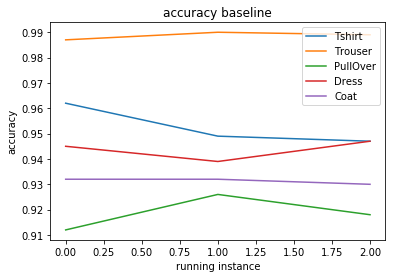

In [14]:
for i, class_name in enumerate(class_names):
    plt.plot(np.arange(n_running_instance), baseline_results[:, i], label=class_name)
plt.title('accuracy baseline')
plt.xlabel('running instance')
plt.ylabel('accuracy')
plt.legend()
plt.show()

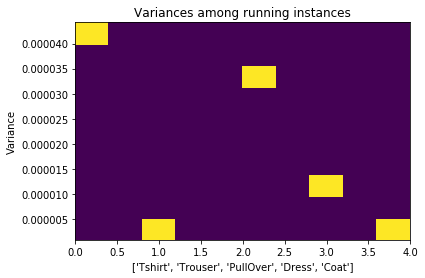

In [15]:
# variance for each class among running instances
baseline_results_var = np.var(baseline_results, axis=0)
# plot variances of each class on different instances
plt.hist2d(range(len(class_names)), baseline_results_var)
plt.title('Variances among running instances')
plt.xlabel(str(class_names))
plt.ylabel('Variance')
plt.show()

In [8]:
num_classes_excluding_other = 9
base_epochs = 10
full_class_ids = np.arange(1, 11) 
full_target_class_ids = full_class_ids[:num_classes_excluding_other]
#full_target_class_ids = np.array([1,2,3,4,5,6,7,8,9])
selected_class_names = [class_names[el] for el in full_target_class_ids]
print('selected classes: ' + str(selected_class_names))



selected classes: ['Tshirt', 'Trouser', 'PullOver', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag']


In [18]:
#full_target_class_ids_all_permutation = list(itertools.permutations(full_target_class_ids))

cur_target_class_ids = np.copy(full_target_class_ids)

GC_refining_results = []
GC_results = []
from_scratch_results = []
from_scratch_result= one_run1(model, x_train, y_train,
                                       x_test, y_test, batch_size, full_target_class_ids,
                                       base_epochs, class_names)
from_scratch_results += [from_scratch_result]

TypeError: one_run1() missing 2 required positional arguments: 'datagen' and 'initial_weights'

In [9]:
print('sequence of class addition: ' + str([class_names[el] for el in full_target_class_ids]))

sequence of class addition: ['Tshirt', 'Trouser', 'PullOver', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag']



======Training From Scratch=========

[32561 10592 24436 47753 25350 54902 36889 49840 43947 30266]
current other class: [ 1  3  5  7  9 10]
current target class: [2 4 6 8]
all target target class: [2 4 6 8]
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 6000
(24000,) (6000,)
Epoch 1/10
30000/30000 [==============================] - 5s 165us/step - loss: 0.7089 - acc: 0.9072
Epoch 2/10
30000/30000 [==============================] - 3s 110us/step - loss: 0.0444 - acc: 0.9857
Epoch 3/10
30000/30000 [==============================] - 3s 110us/step - loss: 0.0156 - acc: 0.9948
Epoch 4/10
30000/30000 [==============================] - 3s 110us/step - loss: 0.0085 - acc: 0.9971
Epoch 5/10
30000/30000 [==============================] - 3s 110us/step - loss: 0.0210 - acc: 0.9951
Epoch 6/10
30000/30000 [==============================] - 3s 110us/step - loss: 0.0038 - acc: 0.9987
Epoch 7/10
30000/30000 [==============================] - 3s 110us/step - loss: 0.0065 - acc: 0

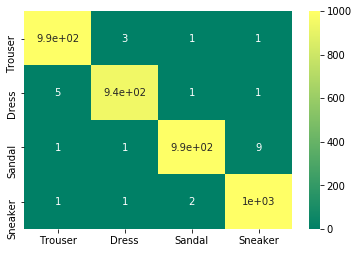


=====Training Using Growing Classifier (new classes appeared in 'Other' class before) ======

[11756 10551 20318  2250 55971 59931 28668 20776  9595 56178]
current other class: [ 1  3  4  5  6  7  8  9 10]
current target class: [2]
all target target class: [2 4 6 8]
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 6000
(6000,) (6000,)
Epoch 1/10
12000/12000 [==============================] - 3s 255us/step - loss: 0.1118 - acc: 0.9887
Epoch 2/10
12000/12000 [==============================] - 1s 109us/step - loss: 0.0207 - acc: 0.9943
Epoch 3/10
12000/12000 [==============================] - 1s 109us/step - loss: 0.0012 - acc: 0.9996
Epoch 4/10
12000/12000 [==============================] - 1s 108us/step - loss: 2.0340e-04 - acc: 1.0000
Epoch 5/10
12000/12000 [==============================] - 1s 108us/step - loss: 7.3856e-04 - acc: 0.9998
Epoch 6/10
12000/12000 [==============================] - 1s 108us/step - loss: 2.5080e-04 - acc: 0.9999
Epoch 7/10
12000/12000 [=

In [51]:
from_scratch_result, GC_refining_result, GC_result = one_run1(model, x_train, y_train, 
                                            x_test, y_test, batch_size, full_target_class_ids, 
                                              base_epochs, class_names)


======Training From Scratch=========

[32160 24010 38641 59813 12381 54341 40488 51487 52897 45202]
current other class: [10]
current target class: [1 2 3 4 5 6 7 8 9]
all target target class: [1, 2, 3, 4, 5, 6, 7, 8, 9]
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 6000
(54000,) (6000,)
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
60000/60000 [==============================] - 9s 145us/step - loss: 1.1652 - acc: 0.5927
Epoch 2/10
60000/60000 [==============================] - 7s 110us/step - loss: 0.6125 - acc: 0.7958
Epoch 3/10
60000/60000 [==============================] - 7s 110us/step - loss: 0.4674 - acc: 0.8425
Epoch 4/10
60000/60000 [==============================] - 7s 110us/step - loss: 0.4029 - acc: 0.8643
Epoch 5/10
60000/60000 [==============================] - 7s 110us/step - loss: 0.3562 - acc: 0.8788
Epoch 6/10
60000/60000 [==============================] - 7s 111us/step - loss: 0.3174 - acc: 0.8888
Epoch 7/10
60000/60000 [==========

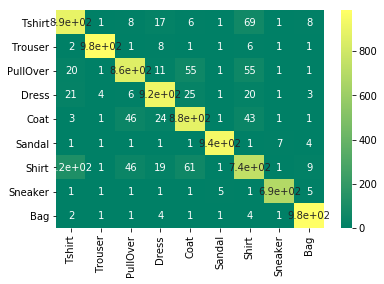


=====Training Using Growing Classifier (new classes appeared in 'Other' class before) ======

[12679 11596 21272  2523 56061 59924 29468 21700 10552 56332]
current other class: [ 2  3  4  5  6  7  8  9 10]
current target class: [1]
all target target class: [1, 2, 3, 4, 5, 6, 7, 8, 9]
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 6000
(6000,) (6000,)
Epoch 1/10
12000/12000 [==============================] - 2s 190us/step - loss: 8.1331 - acc: 0.4148
Epoch 2/10
12000/12000 [==============================] - 1s 111us/step - loss: 8.0590 - acc: 0.5000
Epoch 3/10
12000/12000 [==============================] - 1s 111us/step - loss: 8.0590 - acc: 0.5000
Epoch 4/10
12000/12000 [==============================] - 1s 111us/step - loss: 8.0590 - acc: 0.5000
Epoch 5/10
12000/12000 [==============================] - 1s 111us/step - loss: 8.0590 - acc: 0.5000
Epoch 6/10
12000/12000 [==============================] - 1s 111us/step - loss: 8.0590 - acc: 0.5000
Epoch 7/10
12000/12

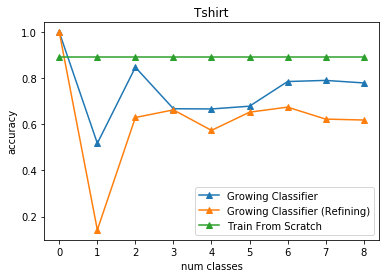

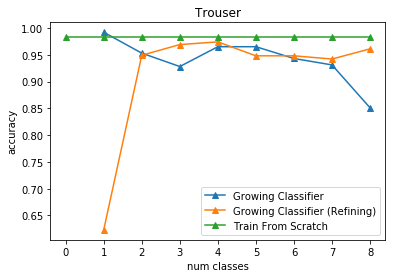

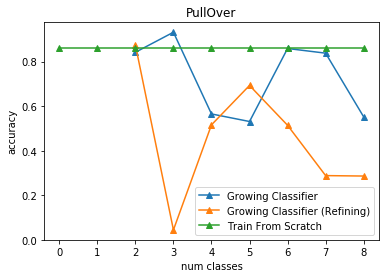

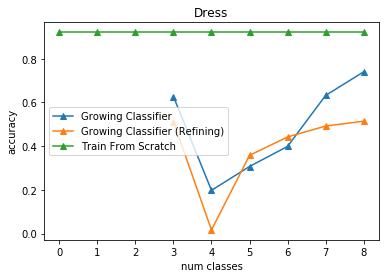

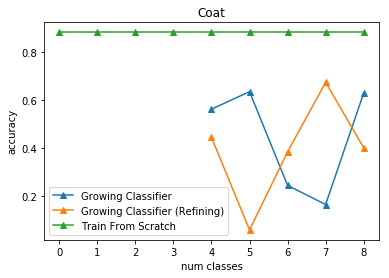

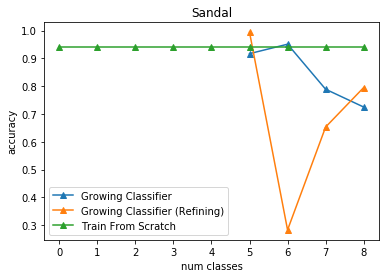

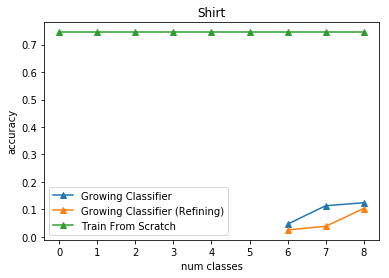

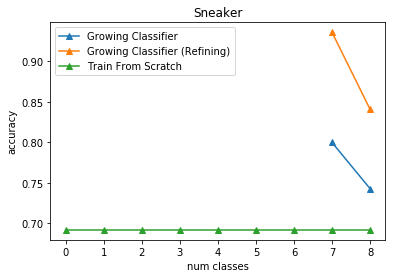

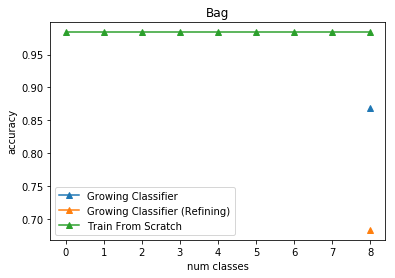

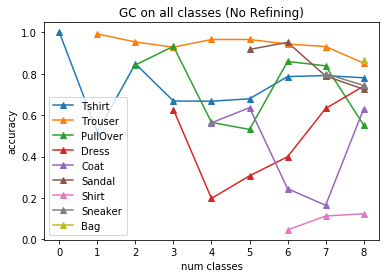

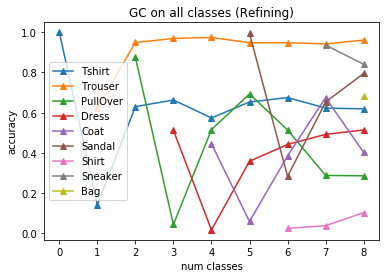

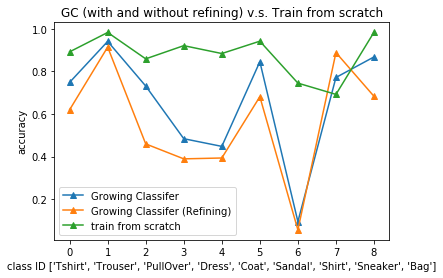

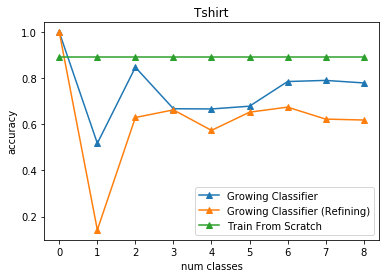

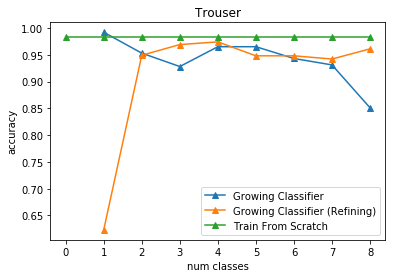

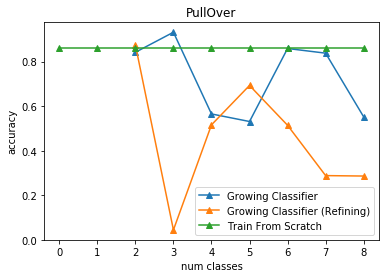

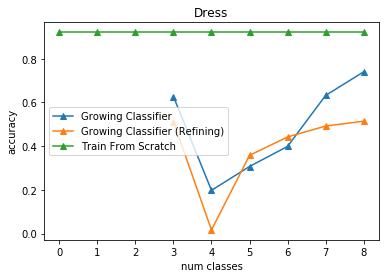

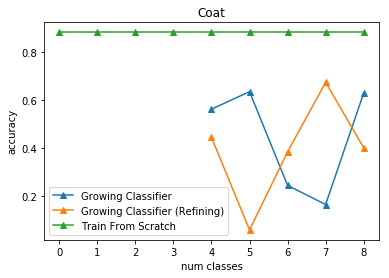

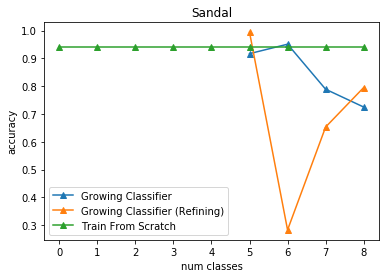

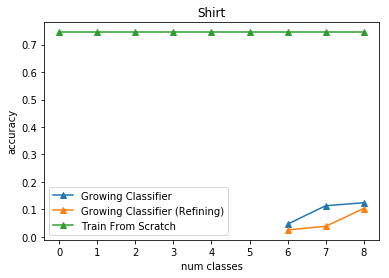

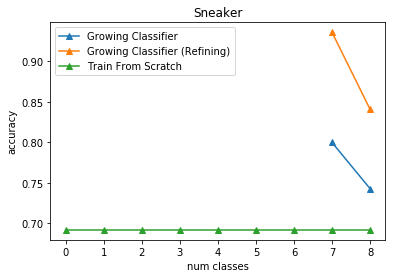

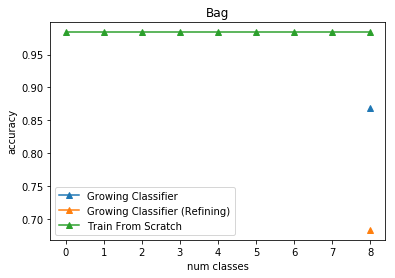

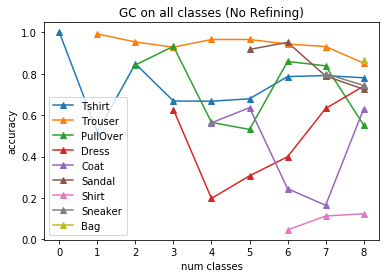

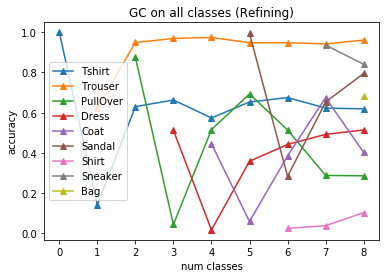

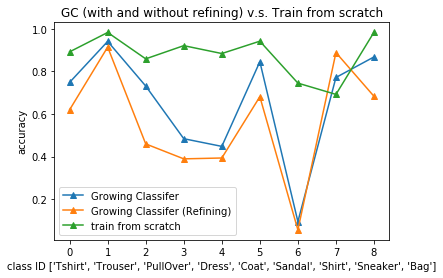

In [14]:

GC_refining_results = []
GC_results = []
from_scratch_result, GC_refining_result, GC_result = one_run1(model, x_train, y_train, 
                                            x_test, y_test, batch_size, full_target_class_ids, 
                                              base_epochs, class_names,datagen,initial_weights)
GC_refining_results += [GC_refining_result]
GC_results += [GC_result]

plot_result(from_scratch_result, GC_result, GC_refining_result, full_target_class_ids, 
                            class_names)



======Training From Scratch=========

[33178 25345 38251 59740 12665 54428 40267 51106 53016 44715]
current other class: [10]
current target class: [1 8 5 2 4 6 9 7 3]
all target target class: [1, 8, 5, 2, 4, 6, 9, 7, 3]
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 6000
(54000,) (6000,)
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
60000/60000 [==============================] - 9s 145us/step - loss: 1.0938 - acc: 0.6127
Epoch 2/10
60000/60000 [==============================] - 7s 110us/step - loss: 0.6175 - acc: 0.7955
Epoch 3/10
60000/60000 [==============================] - 7s 110us/step - loss: 0.4664 - acc: 0.8441
Epoch 4/10
60000/60000 [==============================] - 7s 110us/step - loss: 0.4158 - acc: 0.8619
Epoch 5/10
60000/60000 [==============================] - 7s 111us/step - loss: 0.3568 - acc: 0.8767
Epoch 6/10
60000/60000 [==============================] - 7s 110us/step - loss: 0.3213 - acc: 0.8875
Epoch 7/10
60000/60000 [==========

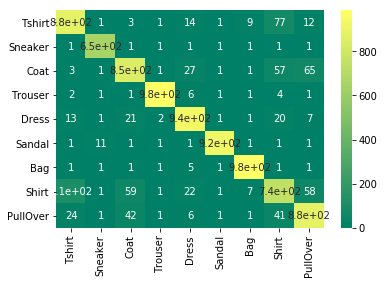


=====Training Using Growing Classifier (new classes appeared in 'Other' class before) ======

[12679 11596 21272  2523 56061 59924 29468 21700 10552 56332]
current other class: [ 2  3  4  5  6  7  8  9 10]
current target class: [1]
all target target class: [1, 8, 5, 2, 4, 6, 9, 7, 3]
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 6000
(6000,) (6000,)
Epoch 1/10
12000/12000 [==============================] - 2s 182us/step - loss: 8.1331 - acc: 0.4148
Epoch 2/10
12000/12000 [==============================] - 1s 109us/step - loss: 8.0590 - acc: 0.5000
Epoch 3/10
12000/12000 [==============================] - 1s 108us/step - loss: 8.0590 - acc: 0.5000
Epoch 4/10
12000/12000 [==============================] - 1s 109us/step - loss: 8.0590 - acc: 0.5000
Epoch 5/10
12000/12000 [==============================] - 1s 114us/step - loss: 8.0590 - acc: 0.5000
Epoch 6/10
12000/12000 [==============================] - 1s 111us/step - loss: 8.0590 - acc: 0.5000
Epoch 7/10
12000/12

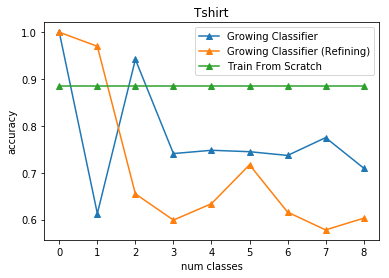

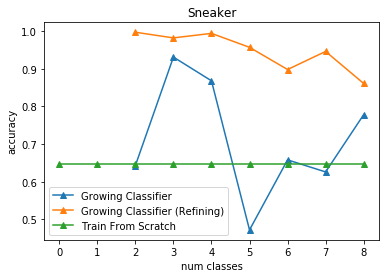

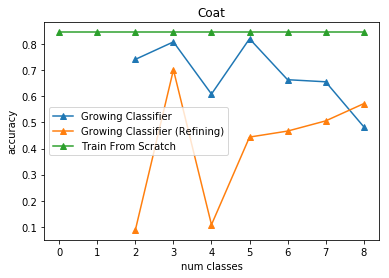

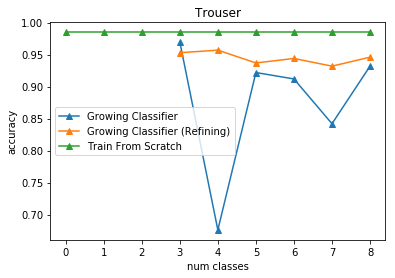

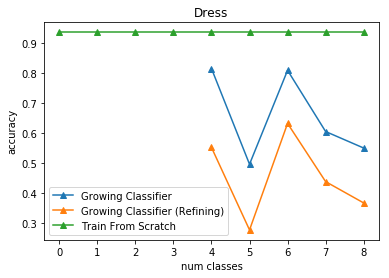

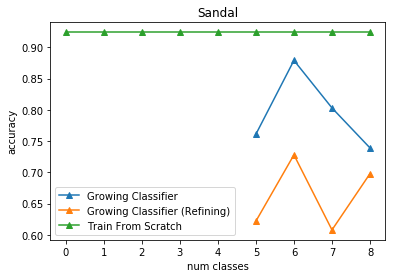

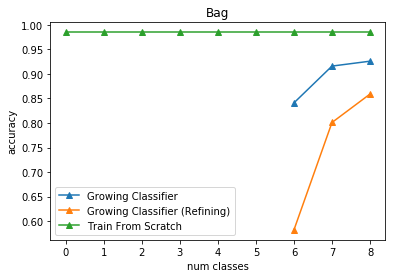

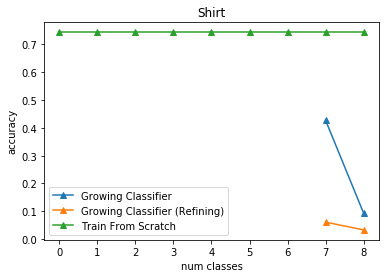

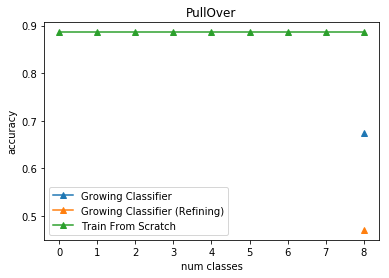

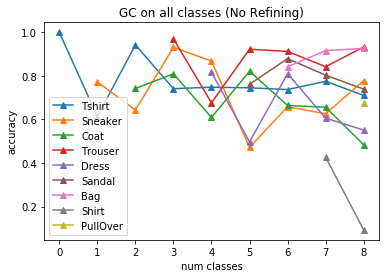

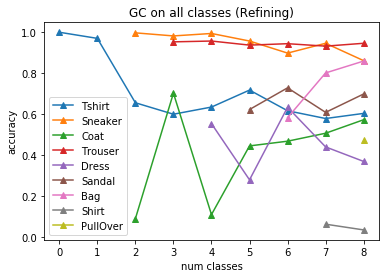

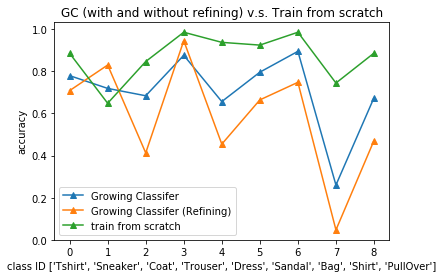

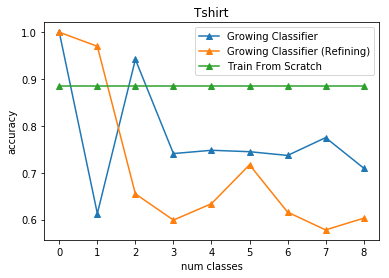

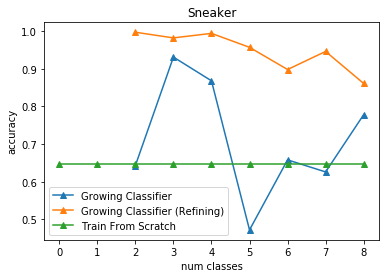

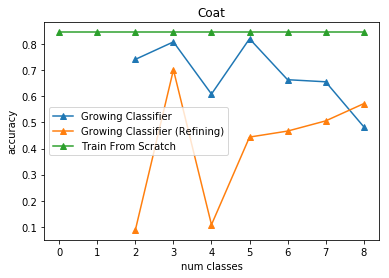

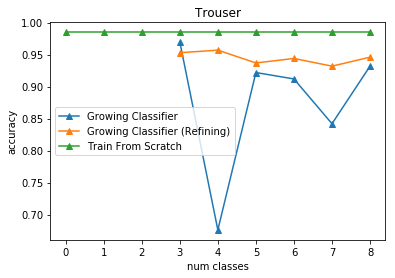

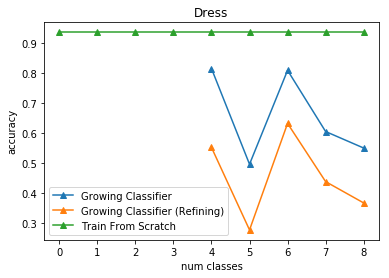

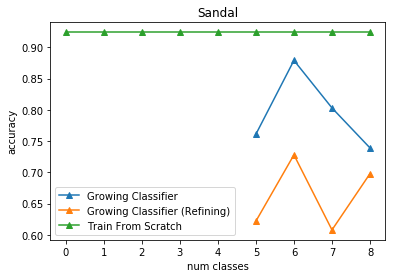

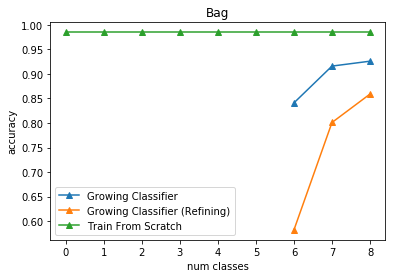

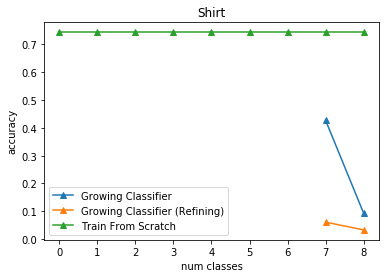

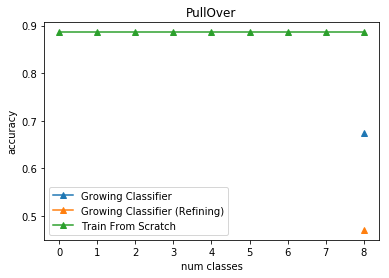

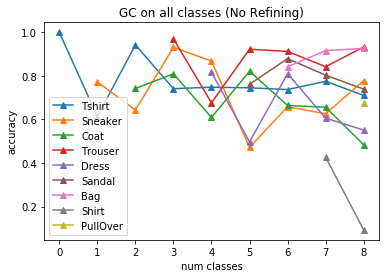

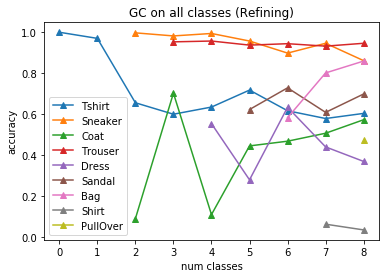

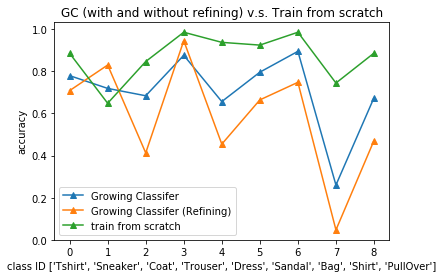

In [13]:

GC_refining_results = []
GC_results = []
from_scratch_result, GC_refining_result, GC_result = one_run1(model, x_train, y_train, 
                                            x_test, y_test, batch_size, full_target_class_ids, 
                                              base_epochs, class_names,datagen,initial_weights)
GC_refining_results += [GC_refining_result]
GC_results += [GC_result]

plot_result(from_scratch_result, GC_result, GC_refining_result, full_target_class_ids, 
                            class_names)


======Training From Scratch=========

[32529 24414 38711 59727 12513 54771 39536 51406 53144 44588]
current other class: [10]
current target class: [1 7 4 2 5 3 8 6 9]
all target target class: [1, 7, 4, 2, 5, 3, 8, 6, 9]
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 6000
(54000,) (6000,)
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
60000/60000 [==============================] - 10s 164us/step - loss: 1.1407 - acc: 0.6005
Epoch 2/10
60000/60000 [==============================] - 7s 110us/step - loss: 0.6059 - acc: 0.7980
Epoch 3/10
60000/60000 [==============================] - 7s 110us/step - loss: 0.4656 - acc: 0.8445
Epoch 4/10
60000/60000 [==============================] - 7s 110us/step - loss: 0.3758 - acc: 0.8675
Epoch 5/10
60000/60000 [==============================] - 7s 110us/step - loss: 0.3396 - acc: 0.8835
Epoch 6/10
60000/60000 [==============================] - 7s 110us/step - loss: 0.3068 - acc: 0.8908
Epoch 7/10
60000/60000 [=========

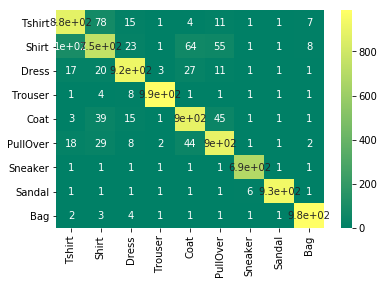


=====Training Using Growing Classifier (new classes appeared in 'Other' class before) ======

[12679 11596 21272  2523 56061 59924 29468 21700 10552 56332]
current other class: [ 2  3  4  5  6  7  8  9 10]
current target class: [1]
all target target class: [1, 7, 4, 2, 5, 3, 8, 6, 9]
all class: [ 1  2  3  4  5  6  7  8  9 10]
all other class indices: 6000
(6000,) (6000,)
Epoch 1/10
12000/12000 [==============================] - 2s 182us/step - loss: 8.1331 - acc: 0.4148
Epoch 2/10
12000/12000 [==============================] - 1s 108us/step - loss: 8.0590 - acc: 0.5000
Epoch 3/10
12000/12000 [==============================] - 1s 108us/step - loss: 8.0590 - acc: 0.5000
Epoch 4/10
12000/12000 [==============================] - 1s 109us/step - loss: 8.0590 - acc: 0.5000
Epoch 5/10
12000/12000 [==============================] - 1s 108us/step - loss: 8.0590 - acc: 0.5000
Epoch 6/10
12000/12000 [==============================] - 1s 109us/step - loss: 8.0590 - acc: 0.5000
Epoch 7/10
12000/12

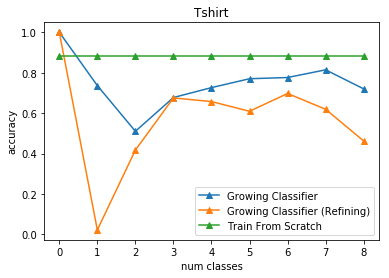

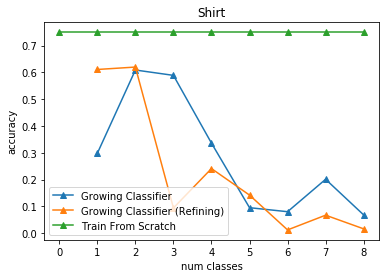

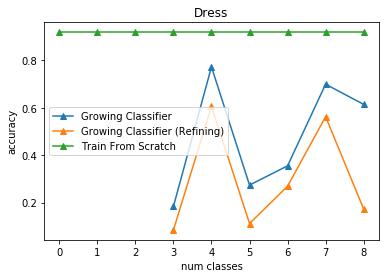

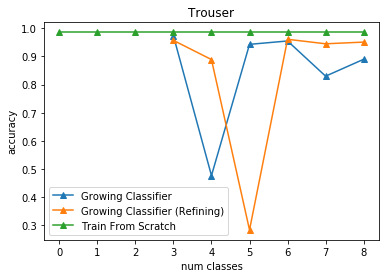

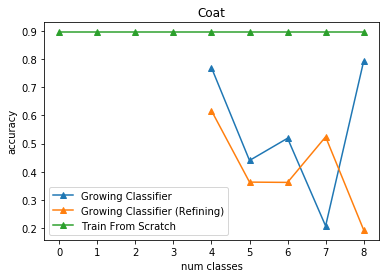

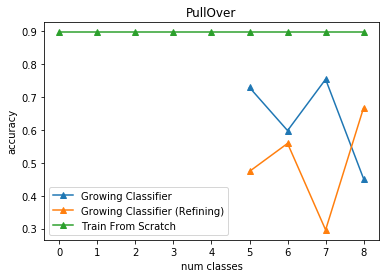

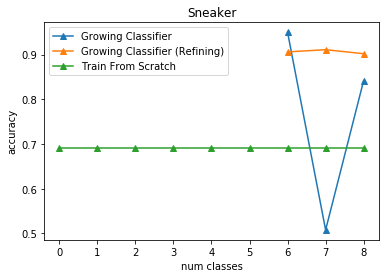

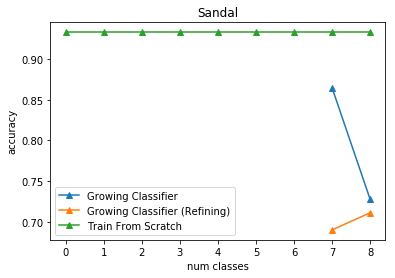

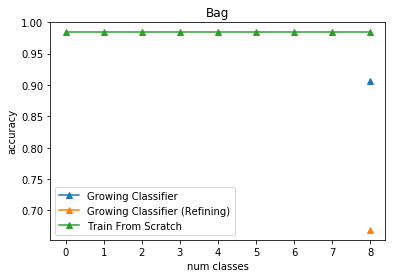

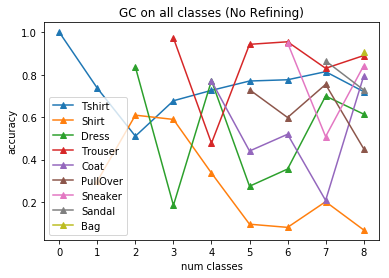

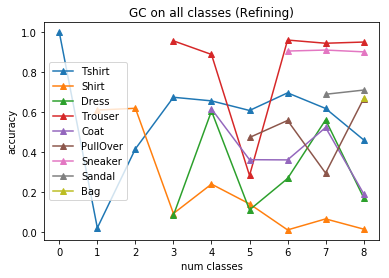

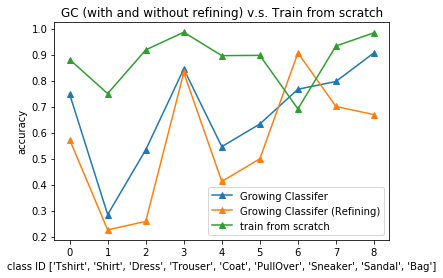

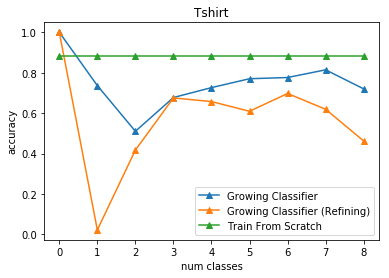

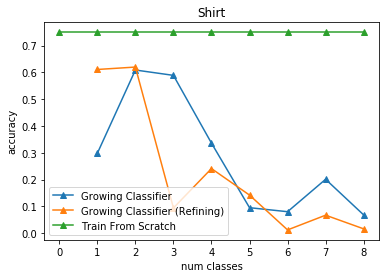

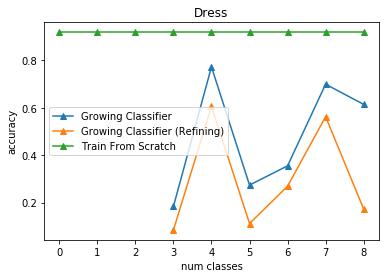

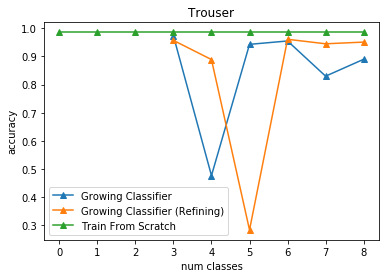

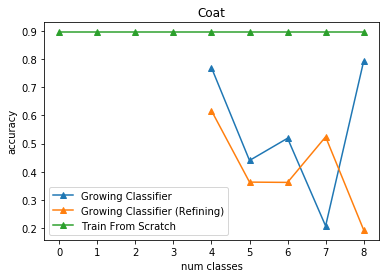

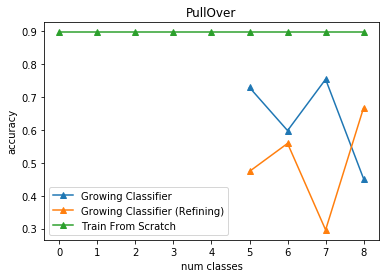

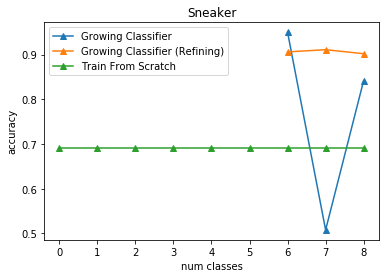

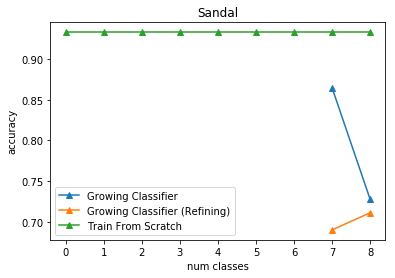

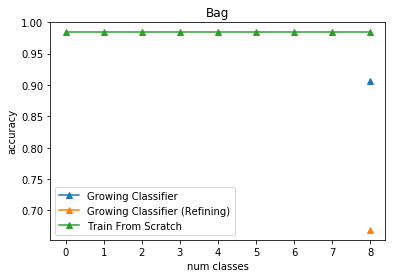

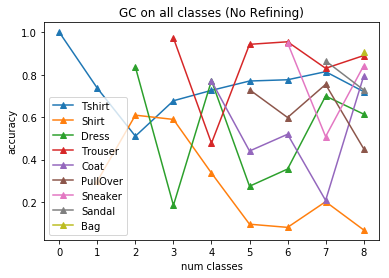

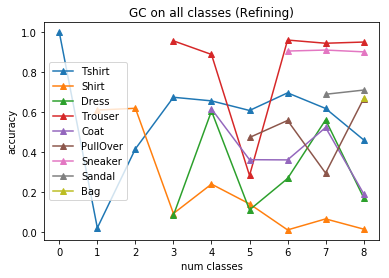

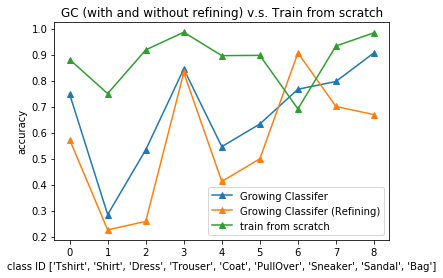

In [16]:
#semantic similairty 

GC_refining_results = []
GC_results = []
from_scratch_result, GC_refining_result, GC_result = one_run1(model, x_train, y_train, 
                                            x_test, y_test, batch_size, full_target_class_ids, 
                                              base_epochs, class_names,datagen,initial_weights)
GC_refining_results += [GC_refining_result]
GC_results += [GC_result]

plot_result(from_scratch_result, GC_result, GC_refining_result, full_target_class_ids, 
                            class_names)